In [1]:
!pip3 -q install diffusers
!pip3 -q install datasets
!pip3 install lpips
!pip install gdown
!gdown --id 1ztkqXJGaW3-19sU5KoE0VM8j4rRVviX1
!kaggle datasets download -d jessicali9530/celeba-dataset
!kaggle datasets download -d m7mdelganainy/celeba-captions
!unzip -q /kaggle/working/celeba-dataset.zip
!unzip -q /kaggle/working/celeba-captions.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ztkqXJGaW3-19sU5KoE0VM8j4rRVviX1
From (redirected): https://drive.google.com/uc?id=1ztkqXJGaW3-19sU5KoE0VM8j4rRVviX1&confirm=t&uuid=2b1c27ae-1793-4679-a0b3-1b0cf329dc6f
To: /kaggle/working/unet_new (5).pth
100%|████████████████████████████████████████| 108M/108M [00:01<00:00, 62.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98%|██████████████████████████████████████▎| 1.30G/1.33G [00:09<00:00, 198MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:09<00:00, 157MB/s]
Dataset URL: https://www.kaggle.com/datasets/m7mdelganainy/celeba-captions
License(s): unknown
 

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline, UNet2DConditionModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# laod json file
with open('/kaggle/working/captions.json') as f:
    data = json.load(f)

In [4]:
df = {
    'image':[],
    'caption':[]
}

num_samples = 100000
for img_name in data.keys():
    caption = data[img_name]['overall_caption']

    df['image'].append(img_name)
    df['caption'].append(caption)

    if len(df['image']) > num_samples:
        break


import pandas as pd
df = pd.DataFrame(df)
df

image                                            caption
0       000001.jpg  The full face of this female is beamed with ha...
1       000002.jpg  There is not any eyeglasses on her face. This ...
2       000003.jpg  This guy doesn't have any beard and has no fri...
3       000004.jpg  This person has no smile, and no eyeglasses. S...
4       000005.jpg  This lady has no bangs, and no glasses. This p...
...            ...                                                ...
99996   100007.jpg  This female has no fringe, no glasses, and a m...
99997   100008.jpg  This person has no bangs, and a face that is b...
99998   100009.jpg  This person doesn't have any bangs and has mus...
99999   100010.jpg  This guy in the middle age has no glasses, no ...
100000  100011.jpg  This young adult has no smile, and no eyeglass...

[100001 rows x 2 columns]

In [5]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize CLIP tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

def get_text_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)

    # Pass through the text encoder
    with torch.no_grad():
        outputs = text_encoder(**inputs)

    # Extract the last hidden state
    last_hidden_state = outputs.last_hidden_state

    return last_hidden_state


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [6]:
get_text_embeddings('hello how are').size()

torch.Size([1, 5, 768])

In [7]:
from diffusers import AutoencoderKL

# Load a pretrained VAE
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
# vae.load_state_dict(torch.load('/kaggle/working/vae_step.pth', weights_only=True))
vae.eval()  # Set the VAE in evaluation mode

def get_image_latent_dist(image):
    with torch.no_grad():
        latent_dist = vae.encode(image).latent_dist.sample()
    return latent_dist


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [8]:
# test vae
x = torch.randn((1,3,256,256)).to(device)
get_image_latent_dist(x).shape

torch.Size([1, 4, 32, 32])

In [9]:
RANDOM_SEED = 42
IMG_SIZE = 256
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
import cv2
import os
from torch.utils.data import DataLoader,Dataset

class Text2ImageDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        self.df = df
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        img_path = os.path.join(self.base_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        caption = self.df.iloc[idx]['caption']
        if self.transform:
            image = self.transform(image)

        return image,caption

In [11]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

base_dir = '/kaggle/working/img_align_celeba/img_align_celeba/'
dataset = Text2ImageDataset(df, base_dir, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

torch.Size([3, 256, 256])
tensor(1.)
tensor(-1.)
('The full face of this female is beamed with happiness. This person looks very young and has no bangs. There is not any glasses on her face.', 'There is not any eyeglasses on her face. This woman is in her middle age and has a big smile with the mouth a bit open, and no bangs.', "This guy doesn't have any beard and has no fringe, and no glasses. This person is in his middle age and has no smile.", 'This person has no smile, and no eyeglasses. She is in her thirties and has no bangs.', 'This lady has no bangs, and no glasses. This person is a teen and has no smile.', 'She has no glasses, and no smile. This lady is in the middle age and has no bangs.', 'This young adult has no bangs, no smile, no beard at all, and no glasses.', "He doesn't have any mustache and has no fringe. This person is in his sixties and has no eyeglasses. He looks serious with no smile in the face.", 'This person has a beaming face, no glasses, and fringe of medium 

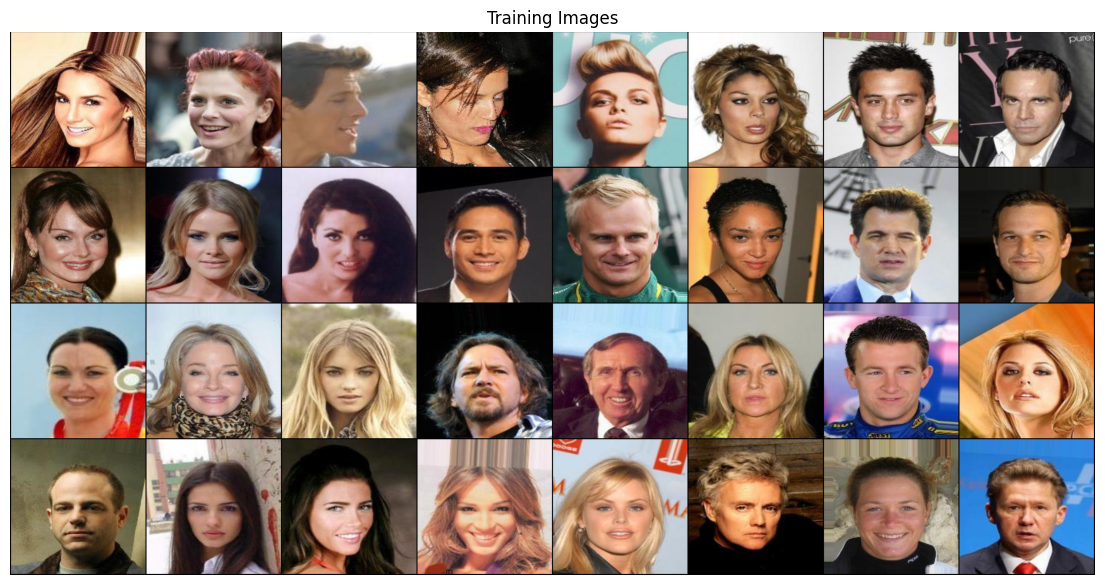

In [12]:
import torchvision.utils as vutils

real_batch,captions = next(iter(train_dataloader))
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")
print(real_batch[0].shape)
print(real_batch[0].max())
print(real_batch[0].min())
print(captions)
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))


In [13]:
model = UNet2DConditionModel(
    sample_size=IMG_SIZE//8,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",

    ),

    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    cross_attention_dim=768
)
model = model.to(device)

model.load_state_dict(torch.load('/kaggle/working/unet_new (5).pth', weights_only=True))

<All keys matched successfully>

In [14]:
# sample_image = dataset[0]["images"].unsqueeze(0).to(device)
sample_image, captions =  next(iter(train_dataloader))
with torch.no_grad():
    print("Input shape", sample_image.shape)
    text_embeddings = get_text_embeddings(captions)
    print('Text embeddings shape',text_embeddings.size())
    image_latent_dist = get_image_latent_dist(sample_image.to(device)).to(device)
    print('Image latent dist shape',image_latent_dist.shape)
    print("Output shape", model(image_latent_dist, timestep=0,encoder_hidden_states=text_embeddings).sample.shape)

Input shape torch.Size([32, 3, 256, 256])
Text embeddings shape torch.Size([32, 43, 768])
Image latent dist shape torch.Size([32, 4, 32, 32])
Output shape torch.Size([32, 4, 32, 32])


In [15]:
def sample_image_generation(model, vae, noise_scheduler, captions, num_generate_images):
    model.eval()
    with torch.no_grad():
        # Initialize noise
        noise = torch.randn(num_generate_images, 4, IMG_SIZE // 8, IMG_SIZE // 8).to(device)

        # Get conditioned text embeddings (for guidance)
        text_embeddings = get_text_embeddings(captions)

        # Denoising loop
        for t in tqdm(noise_scheduler.timesteps, position=0, leave=True):
            # Predict noise with conditioning (guided)
            noise_pred = model(noise, t, text_embeddings).sample

            # Update the noise with the new prediction
            noise = noise_scheduler.step(noise_pred, t, noise).prev_sample

        # Decode the noise to generate images
        noise = noise / 0.18215  # Undo the latent scaling
        images = vae.decode(noise).sample
        
#         images = vae(images).sample
        # Print the captions
        for caption in captions:
            print(f'- {caption}')

        # Plot the generated images
        fig = plt.figure(figsize=(20, 20))
        for i in range(1, num_generate_images + 1):
            fig.add_subplot(4, 4, i)
            # Convert tensor to numpy for visualization
            img = images[i - 1].cpu().permute(1, 2, 0).numpy()
            img = (img + 1) / 2  # Rescale to [0, 1]
            plt.imshow(img)
            plt.axis('off')
        plt.show()


In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise_scheduler.set_timesteps(num_inference_steps=20)

100%|██████████| 20/20 [00:00<00:00, 29.85it/s]


- This person in his forties has no beard at all, no eyeglasses, and no fringe. This corners of his mouth curve up and we can see some teeth.
- There is not any glasses on the face and has no smile, and no bangs. This female is in the thirties.
- This person is smiling with the mouth only a little open and has no bangs, and no eyeglasses. This lady is a teen.
- This teen has short fringe, no mustache at all, no smile, and no eyeglasses.


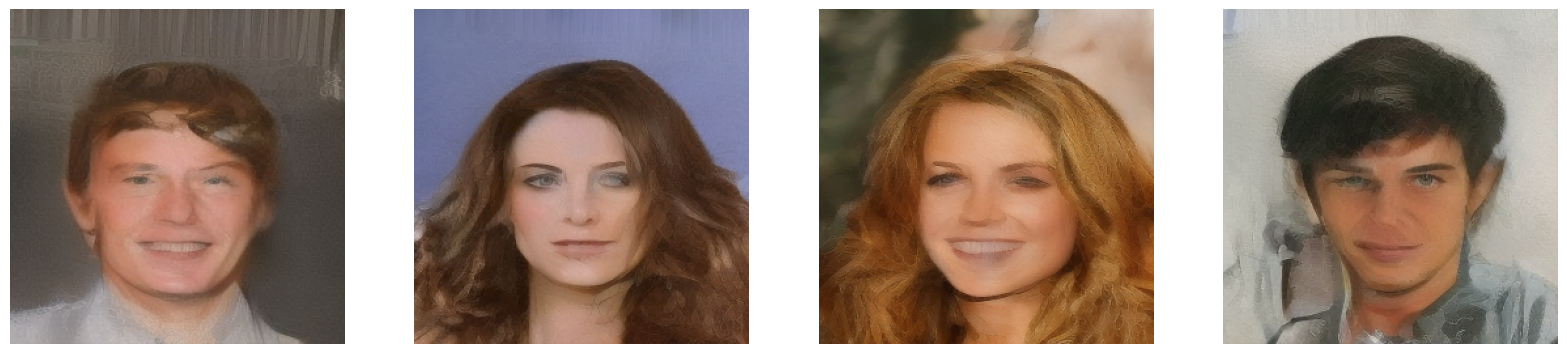

In [17]:
fixed_captions = (
'This person in his forties has no beard at all, no eyeglasses, and no fringe. This corners of his mouth curve up and we can see some teeth.',
 'There is not any glasses on the face and has no smile, and no bangs. This female is in the thirties.',
 'This person is smiling with the mouth only a little open and has no bangs, and no eyeglasses. This lady is a teen.',
 'This teen has short fringe, no mustache at all, no smile, and no eyeglasses.',
)

sample_image_generation(model,vae, noise_scheduler,fixed_captions, len(fixed_captions))



In [18]:
# noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
# noise_scheduler.set_timesteps(num_inference_steps=10)

In [19]:
NUM_EPOCHS = 200
LEARNING_RATE = 7e-6

In [20]:
text_embdeddings_history = {}
image_latent_dist_history = {}

In [21]:
import copy

class EMAModel:
    def __init__(self, model, decay=0.999):
        self.ema_model = copy.deepcopy(model)  # Initialize EMA model as a copy of the original model
        self.decay = decay
        self.ema_has_been_updated = False  # Track if EMA has been applied at least once

    def update(self, model):
        for ema_param, model_param in zip(self.ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(self.decay).add_(model_param.data, alpha=(1.0 - self.decay))
        self.ema_has_been_updated = True

    def apply(self, model):
        if not self.ema_has_been_updated:
            return model  # Use original model if EMA hasn't been updated yet
        return self.ema_model

# Initialize EMA
ema = EMAModel(model, decay=0.999)

# Update training loop to include EMA updates
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader) * NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

In [22]:
# import lpips

# # Load the LPIPS model
# lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)

# def compute_perceptual_loss(real_image, reconstructed_image):
#     return lpips_loss_fn(real_image, reconstructed_image).mean()

In [23]:
# for param in vae.parameters():
#     param.requires_grad = False

# for param in vae.decoder.parameters():
#     param.requires_grad = True
    
# vae.train()

100%|██████████| 20/20 [00:00<00:00, 25.22it/s]


- This person in his forties has no beard at all, no eyeglasses, and no fringe. This corners of his mouth curve up and we can see some teeth.
- There is not any glasses on the face and has no smile, and no bangs. This female is in the thirties.
- This person is smiling with the mouth only a little open and has no bangs, and no eyeglasses. This lady is a teen.
- This teen has short fringe, no mustache at all, no smile, and no eyeglasses.


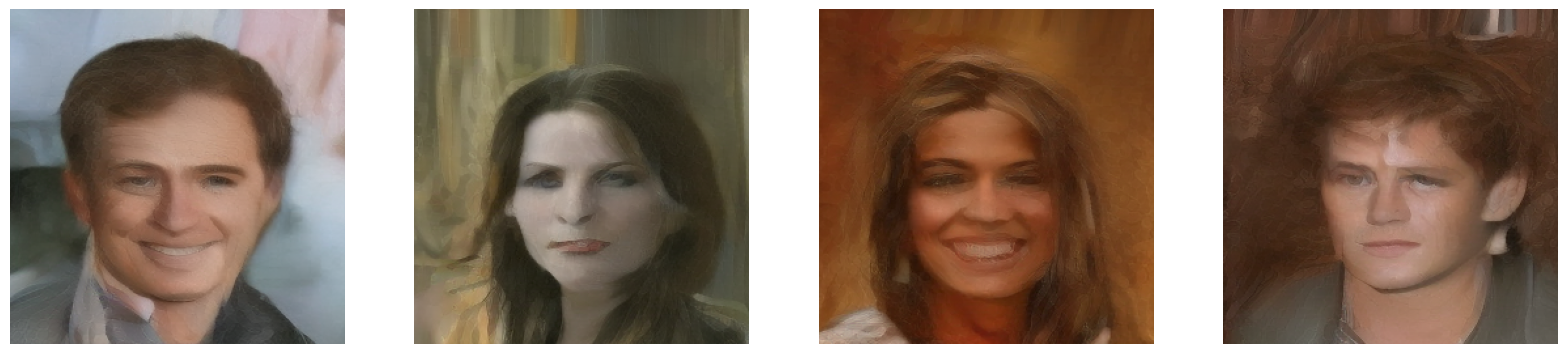

100%|██████████| 20/20 [00:00<00:00, 34.94it/s]00/3126 [28:32<1:01:01,  1.72s/it]


- This person in his forties has no beard at all, no eyeglasses, and no fringe. This corners of his mouth curve up and we can see some teeth.
- There is not any glasses on the face and has no smile, and no bangs. This female is in the thirties.
- This person is smiling with the mouth only a little open and has no bangs, and no eyeglasses. This lady is a teen.
- This teen has short fringe, no mustache at all, no smile, and no eyeglasses.


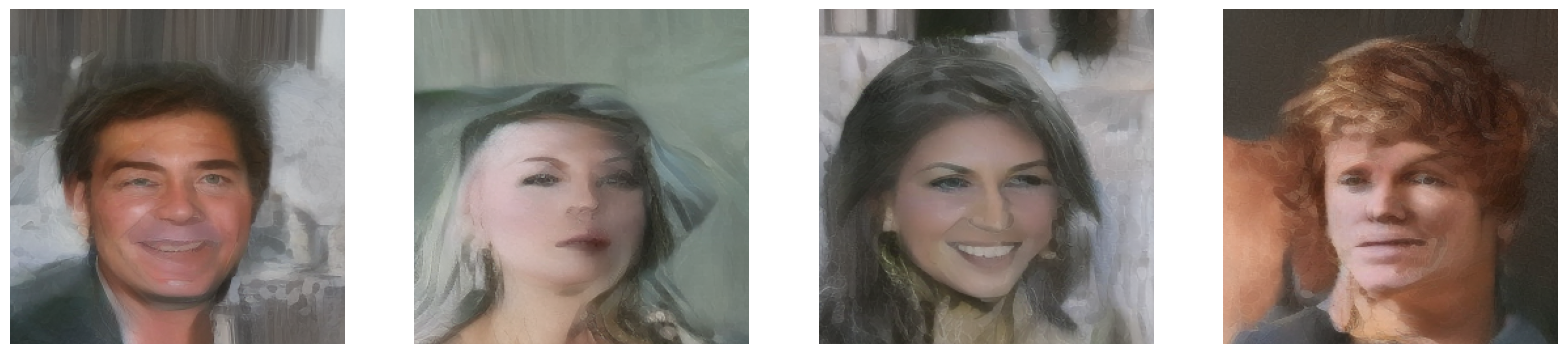

100%|██████████| 20/20 [00:00<00:00, 34.42it/s]00/3126 [57:10<32:09,  1.71s/it]  


- This person in his forties has no beard at all, no eyeglasses, and no fringe. This corners of his mouth curve up and we can see some teeth.
- There is not any glasses on the face and has no smile, and no bangs. This female is in the thirties.
- This person is smiling with the mouth only a little open and has no bangs, and no eyeglasses. This lady is a teen.
- This teen has short fringe, no mustache at all, no smile, and no eyeglasses.


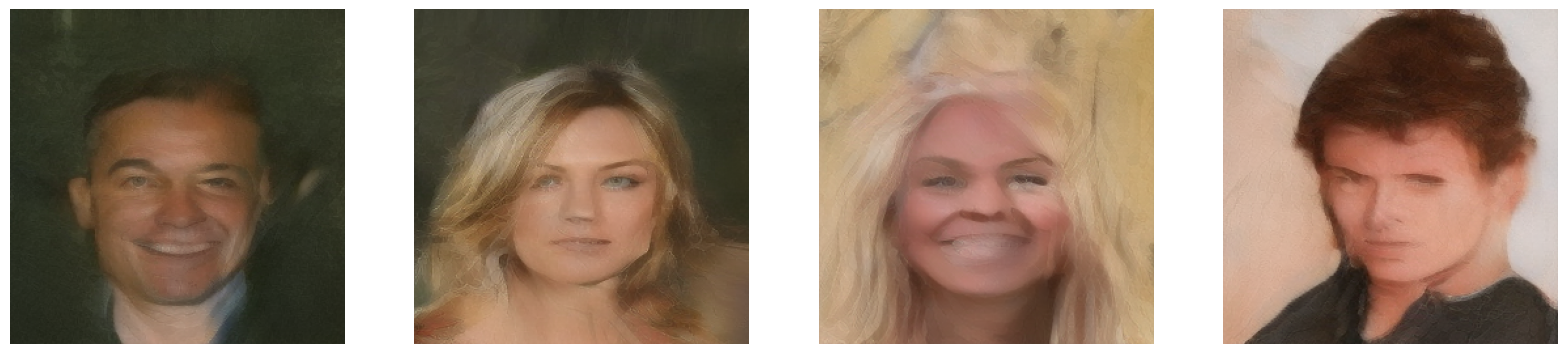

Epoch [1/200] Loss: 0.1382:  66%|██████▌   | 2050/3126 [58:38<30:47,  1.72s/it]

In [ ]:
start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    total_batches = len(train_dataloader)
    progress_bar = tqdm(train_dataloader, position=0, leave=True)

    for idx, (images, captions) in enumerate(progress_bar):
        images = images.to(device)

        if idx in text_embdeddings_history:
            text_embeddings = text_embdeddings_history[idx].to(device)
        else:
            text_embeddings = get_text_embeddings(captions).to(device)
            text_embdeddings_history[idx] = text_embeddings.cpu()

        if idx in image_latent_dist_history:
            image_latent_dist = image_latent_dist_history[idx].to(device)
        else:
            image_latent_dist = get_image_latent_dist(images).to(device)
            image_latent_dist = image_latent_dist * 0.18215
            image_latent_dist_history[idx] = image_latent_dist.cpu()

        noise = torch.randn(image_latent_dist.shape).to(device)
        last_batch_size = len(noise)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_image_latent_dist = noise_scheduler.add_noise(image_latent_dist, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_image_latent_dist, timesteps, text_embeddings, return_dict=False)[0]
#             decoded_images = vae.decode(noise_pred/0.18215,return_dict=False)[0]
            

            loss = F.mse_loss(noise_pred, noise)
#             # Compute perceptual loss between original and reconstructed images
#             perceptual_loss = compute_perceptual_loss(images, decoded_images)

            # Total loss: MSE + Perceptual (LPIPS) loss
#             loss = mse_loss + 0.3*perceptual_loss
            
            
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        if idx % 1000 == 0:
          sample_image_generation(ema.apply(model), vae, noise_scheduler, fixed_captions, len(fixed_captions))
#           torch.save(model.state_dict(), '/kaggle/working/unet_step_new.pth')          
#           torch.save(vae.state_dict(), '/kaggle/working/vae_step.pth')


        # Update EMA
        ema.update(model)

        train_running_loss += loss.item()
        avg_loss = train_running_loss / (idx + 1)
        progress_bar.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {avg_loss:.4f}")

    train_loss = train_running_loss / total_batches
    train_learning_rate = lr_scheduler.get_last_lr()[0]

    print("-" * 30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")

    # Use EMA model for evaluation and image generation
    if epoch % 1 == 0:
        sample_image_generation(ema.apply(model), vae, noise_scheduler, fixed_captions, len(fixed_captions))

    print("-" * 30)
    torch.save(model.state_dict(), '/kaggle/working/unet_new.pth')

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise_scheduler.set_timesteps(num_inference_steps=10)

In [ ]:
captions = ['this person is female,with beatufull eyes,long blonde hair, smile',
            'This person in his forties has no beard at all.',
            'This person,beard, smile, and long hair',
            'this person is lady in her forties,long hair,no smile',
            'this teen have black hair, no smile, series',
            'this teen have blon hair, smile',
            'this old have beard,smile',
            'a male ,with long hair and small mouth'

           ]
sample_image_generation(model,vae, noise_scheduler, captions,len(captions))

In [ ]:
captions = [
    'this person, smile, with sunglasses, has full beard'
           ]
sample_image_generation(model,vae, noise_scheduler, captions,len(captions))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/unet.pth /content/drive/MyDrive